# Introduction

Taxi services play a crucial role in New York City’s transportation system. The NYC Taxi and Limousine Commission (TLC) provides detailed, publicly available datasets on taxi trip records to promote transparency and data-driven improvements.

 This project aims to utilize historical Yellow Taxi trip data to develop a robust machine learning model that can accurately predict the **fare amount** of a trip based on various features like trip distance, duration, number of passengers, pickup/dropoff locations.
Understanding fare structures and building accurate predictive models can benefit both the transportation sector and passengers by:
 - Building fare estimate tools for riders
 - Improving taxi dispatch efficiency

## NYC Taxi Trip Data Dictionary

### Field Descriptions

**VendorID**  
A code indicating the TPEP provider that provided the record.  
1 = Creative Mobile Technologies, LLC  
2 = Curb Mobility, LLC  
6 = Myle Technologies Inc  
7 = Helix  

**tpep_pickup_datetime**  
The date and time when the meter was engaged.

**tpep_dropoff_datetime**  
The date and time when the meter was disengaged.

**passenger_count**  
The number of passengers in the vehicle.

**trip_distance**  
The elapsed trip distance in miles reported by the taximeter.

**RatecodeID**  
The final rate code in effect at the end of the trip.  
1 = Standard rate  
2 = JFK  
3 = Newark  
4 = Nassau or Westchester  
5 = Negotiated fare  
6 = Group ride  
99 = Null/unknown  

**store_and_fwd_flag**  
Indicates whether the trip record was held in vehicle memory before sending to the vendor.  
Y = store and forward trip  
N = not a store and forward trip  

**PULocationID**  
TLC Taxi Zone in which the taximeter was engaged.

**DOLocationID**  
TLC Taxi Zone in which the taximeter was disengaged.

**payment_type**  
A numeric code signifying how the passenger paid for the trip.  
0 = Flex Fare trip  
1 = Credit card  
2 = Cash  
3 = No charge  
4 = Dispute  
5 = Unknown  
6 = Voided trip  


## Reference 
**(https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)**

# Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")


# Loading Dataset

In [2]:
df= pd.read_parquet("yellow_tripdata_2025-06.parquet")

# df=pd.read_csv("yellow_tripdata_2025-06.csv") --- > Use this Code for Downloadable csv File from repository

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-06-01 00:02:50,2025-06-01 00:39:51,1.0,10.00,1.0,N,138,50,1,47.8,11.00,0.5,20.15,6.94,1.0,87.39,2.5,1.75,0.75
1,2,2025-06-01 00:11:27,2025-06-01 00:35:35,1.0,3.93,1.0,N,158,237,1,24.7,1.00,0.5,6.09,0.00,1.0,36.54,2.5,0.00,0.75
2,1,2025-06-01 00:43:47,2025-06-01 00:49:16,0.0,0.70,1.0,N,230,163,1,7.2,4.25,0.5,2.59,0.00,1.0,15.54,2.5,0.00,0.75
3,1,2025-06-01 00:01:15,2025-06-01 00:42:16,1.0,17.00,2.0,N,132,232,1,70.0,3.25,0.5,5.00,0.00,1.0,79.75,2.5,0.00,0.75
4,7,2025-06-01 00:16:32,2025-06-01 00:16:32,1.0,2.22,1.0,N,48,234,1,20.5,0.00,0.5,5.25,0.00,1.0,31.50,2.5,0.00,0.75


In [4]:
# Creating a subset of required columns

df= df[['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4322960 entries, 0 to 4322959
Data columns (total 11 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
dtypes: datetime64[us](2), float64(4), int32(3), int64(1), object(1)
memory usage: 313.3+ MB


In [6]:
df.shape

(4322960, 11)

In [7]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount
count,4.322960e+06,4322960,4322960,3.110014e+06,4.322960e+06,3.110014e+06,4.322960e+06,4.322960e+06,4.322960e+06,4.322960e+06
mean,1.887364e+00,2025-06-15 23:11:14.554075,2025-06-15 23:28:39.149324,1.298270e+00,7.478361e+00,2.599210e+00,1.600238e+02,1.601093e+02,8.912664e-01,1.897800e+01
min,1.000000e+00,2025-05-31 22:34:26,2025-05-31 22:43:36,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.900000e+02
25%,2.000000e+00,2025-06-08 05:03:50.750000,2025-06-08 05:19:49.500000,1.000000e+00,1.070000e+00,1.000000e+00,1.140000e+02,1.070000e+02,0.000000e+00,9.300000e+00
50%,2.000000e+00,2025-06-15 17:58:00,2025-06-15 18:15:00.500000,1.000000e+00,1.920000e+00,1.000000e+00,1.610000e+02,1.620000e+02,1.000000e+00,1.420000e+01
75%,2.000000e+00,2025-06-23 13:25:21,2025-06-23 13:44:24.250000,1.000000e+00,3.900000e+00,1.000000e+00,2.310000e+02,2.330000e+02,1.000000e+00,2.397000e+01
max,7.000000e+00,2025-06-30 23:59:59,2025-07-01 22:36:42,9.000000e+00,2.612624e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,3.254780e+05
std,7.588800e-01,NaN,NaN,7.330376e-01,6.942321e+02,1.200176e+01,6.686664e+01,7.091911e+01,7.697741e-01,1.577826e+02


# Data Preprocessing 

In [8]:
# Correcting Data types 
cat_cols =['VendorID', 'RatecodeID', 'store_and_fwd_flag','PULocationID', 'DOLocationID', 'payment_type']
for col in cat_cols :
    df[col] = df[col].astype('object')

In [9]:
## Feature Extraction 

df['dayofweek'] = (df['tpep_pickup_datetime'].dt.dayofweek).astype('object')  # dayofweek
df['isnight'] = (df['tpep_pickup_datetime'].dt.hour < 6) |( df['tpep_pickup_datetime'].dt.hour > 20)  # Day of Night
df['Travel_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()   # total Travel Time
df['PickUp_time'] = df['tpep_pickup_datetime'].dt.hour+df['tpep_pickup_datetime'].dt.minute/60+df['tpep_pickup_datetime'].dt.second/3600


In [10]:
## drop DateTime Column
df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'],inplace=True,axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4322960 entries, 0 to 4322959
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   VendorID            object 
 1   passenger_count     float64
 2   trip_distance       float64
 3   RatecodeID          object 
 4   store_and_fwd_flag  object 
 5   PULocationID        object 
 6   DOLocationID        object 
 7   payment_type        object 
 8   fare_amount         float64
 9   dayofweek           object 
 10  isnight             bool   
 11  Travel_time         float64
 12  PickUp_time         float64
dtypes: bool(1), float64(5), object(7)
memory usage: 399.9+ MB


In [12]:
# selecting Valid data 

df= df[df['fare_amount']>0]  # Fair amount must not be zero
df= df[df['trip_distance']>0]  # Trip Distance must be above zero 
df= df[df['Travel_time']>60]   # Travel time must be above 60 seconds 

In [13]:
num_cols = df.select_dtypes(exclude ='object').columns.tolist()
for num in num_cols: 
    df[num] = df[num].abs()

### Checking for Duplicates

In [14]:
df.duplicated().sum()

0

In [15]:
df[df.duplicated(keep = False)]

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,dayofweek,isnight,Travel_time,PickUp_time


In [16]:
df.drop_duplicates(inplace = True)

In [17]:
df.duplicated().sum() # removed all duplicate records

0

### Handling Null Values 

In [18]:
df.isnull().sum()

VendorID                   0
passenger_count       935387
trip_distance              0
RatecodeID            935387
store_and_fwd_flag    935387
PULocationID               0
DOLocationID               0
payment_type               0
fare_amount                0
dayofweek                  0
isnight                    0
Travel_time                0
PickUp_time                0
dtype: int64

In [19]:
# Filling Null Values with mode values 

df['passenger_count'] = df['passenger_count'].fillna(df['passenger_count'].mode()[0])
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].fillna(df['store_and_fwd_flag'].mode()[0])
df['RatecodeID'] = df['RatecodeID'].fillna(df['RatecodeID'].mode()[0])


In [20]:
df['RatecodeID']=df['RatecodeID'].astype('object') # Changing type back to object 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3856864 entries, 0 to 4322959
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   VendorID            object 
 1   passenger_count     float64
 2   trip_distance       float64
 3   RatecodeID          object 
 4   store_and_fwd_flag  object 
 5   PULocationID        object 
 6   DOLocationID        object 
 7   payment_type        object 
 8   fare_amount         float64
 9   dayofweek           object 
 10  isnight             bool   
 11  Travel_time         float64
 12  PickUp_time         float64
dtypes: bool(1), float64(5), object(7)
memory usage: 386.2+ MB


# Data Selection

In [22]:
#df = df.sample(n=100000 , random_state = 43) # selecting Random 100000 data for modeling 

# Due to Computational Capabiilities and  faster Computation lets use 10000 samples

df = df.sample(n=10000 , random_state = 43)

# EDA 

In [23]:
df. info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 3062430 to 2513766
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   VendorID            10000 non-null  object 
 1   passenger_count     10000 non-null  float64
 2   trip_distance       10000 non-null  float64
 3   RatecodeID          10000 non-null  object 
 4   store_and_fwd_flag  10000 non-null  object 
 5   PULocationID        10000 non-null  object 
 6   DOLocationID        10000 non-null  object 
 7   payment_type        10000 non-null  object 
 8   fare_amount         10000 non-null  float64
 9   dayofweek           10000 non-null  object 
 10  isnight             10000 non-null  bool   
 11  Travel_time         10000 non-null  float64
 12  PickUp_time         10000 non-null  float64
dtypes: bool(1), float64(5), object(7)
memory usage: 1.0+ MB


df.shape

In [24]:
df.describe()

,passenger_count,trip_distance,fare_amount,Travel_time,PickUp_time
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.218100,3.587655,20.568521,1043.593700,14.506574
std,0.648671,4.339148,17.046528,1186.048215,6.229842
min,0.000000,0.010000,0.530000,61.000000,0.001111
25%,1.000000,1.130000,10.000000,505.000000,10.471458
50%,1.000000,1.940000,14.900000,808.000000,15.367222
75%,1.000000,3.900000,24.700000,1302.000000,19.450694
max,6.000000,66.300000,307.500000,85907.000000,23.991389


### Outlier detection 

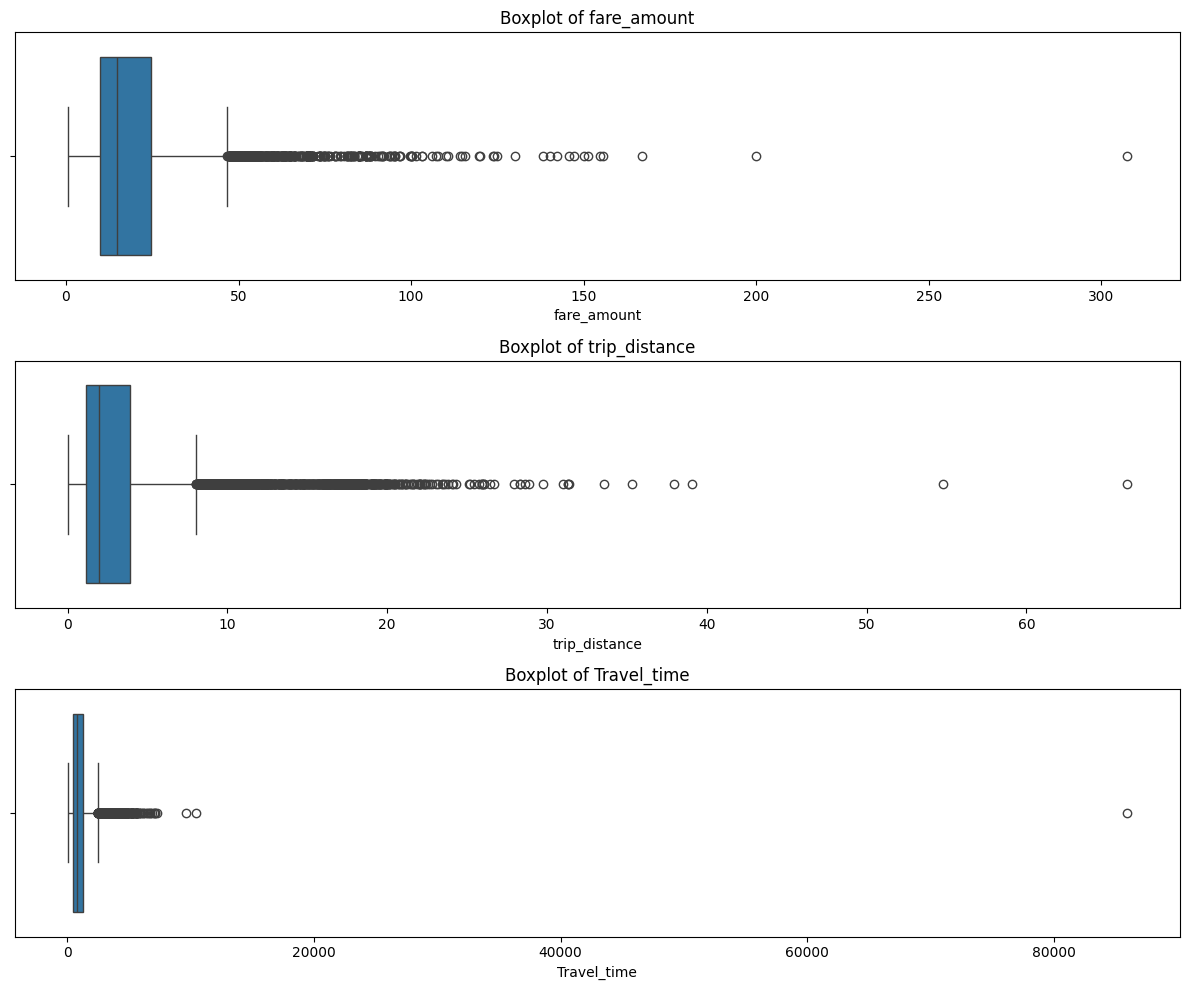

In [25]:
cols1 = ['fare_amount', 'trip_distance', 'Travel_time']

plt.figure(figsize=(12, 10))

for i, col in enumerate(cols1, 1):
    plt.subplot(len(cols1), 1, i) 
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

In [26]:
def IQRmethod(dataframe, K):
    Q1 = dataframe.quantile(0.25)  
    Q3 = dataframe.quantile(0.75)  
    IQR = Q3 - Q1  
    LB = Q1 - K * IQR
    UB = Q3 + K * IQR
    return LB, UB
    

In [27]:
LB,UB = IQRmethod(df['trip_distance'], 5)
df = df[(df['trip_distance']>LB) & (df['trip_distance']<UB)]
LB,UB

(-12.719999999999999, 17.75)

In [28]:
LB,UB = IQRmethod(df['Travel_time'],5)
df = df[(df['Travel_time']>LB) & (df['Travel_time']<UB)]
LB,UB

(-3286.0, 5041.0)

In [29]:
LB,UB = IQRmethod(df['fare_amount'],5)
df = df[(df['fare_amount']>LB) & (df['fare_amount']<UB)]
LB,UB

(-57.5, 91.0)

In [30]:
df.shape

(9743, 13)

In [31]:
100-(df.shape[0]/100000 * 100 ) # percentage of data loss due to outliers 

90.257

## Univariate Analysis


In [32]:
num_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'Travel_time', 'PickUp_time']
cat_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
            'DOLocationID', 'payment_type', 'dayofweek']
bool_cols = ['isnight']

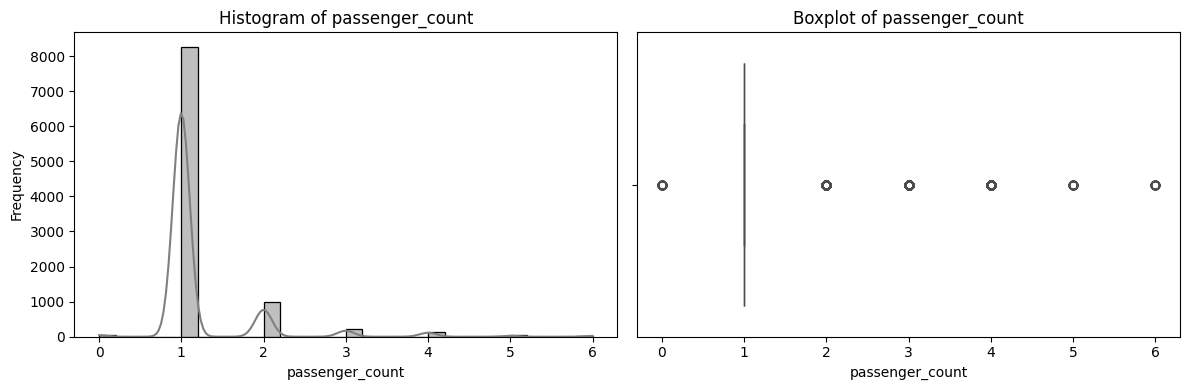

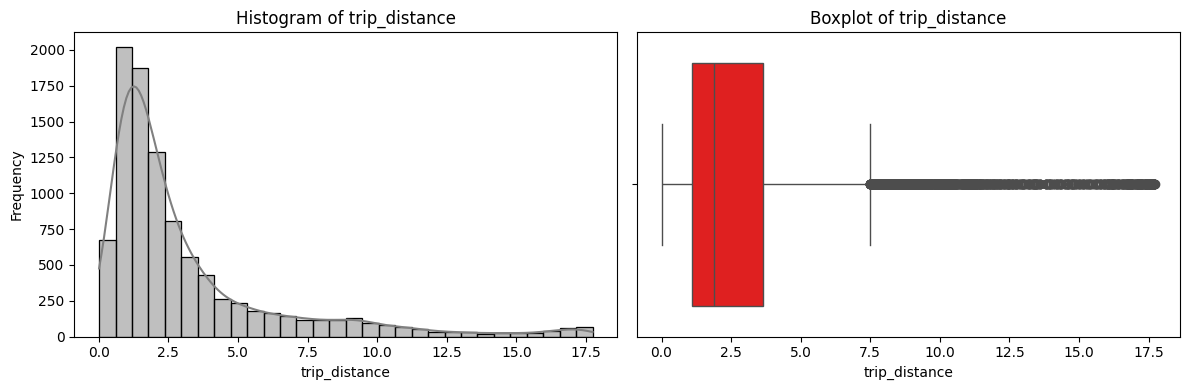

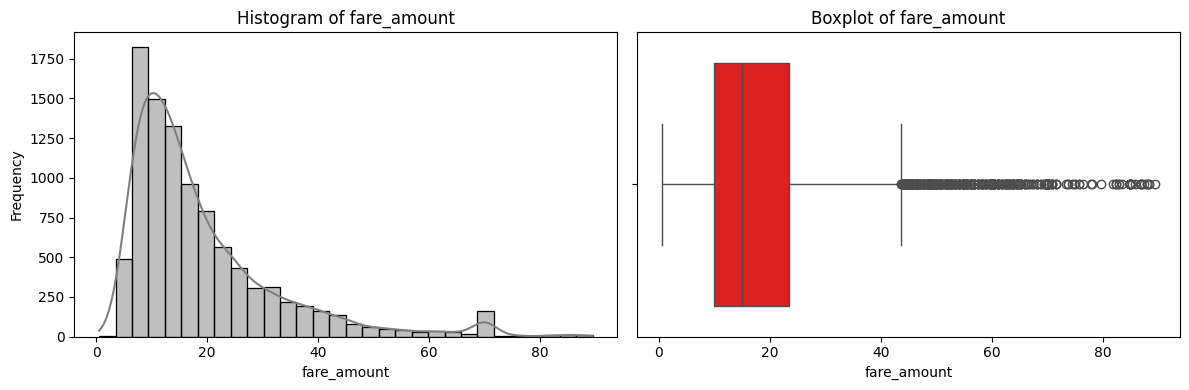

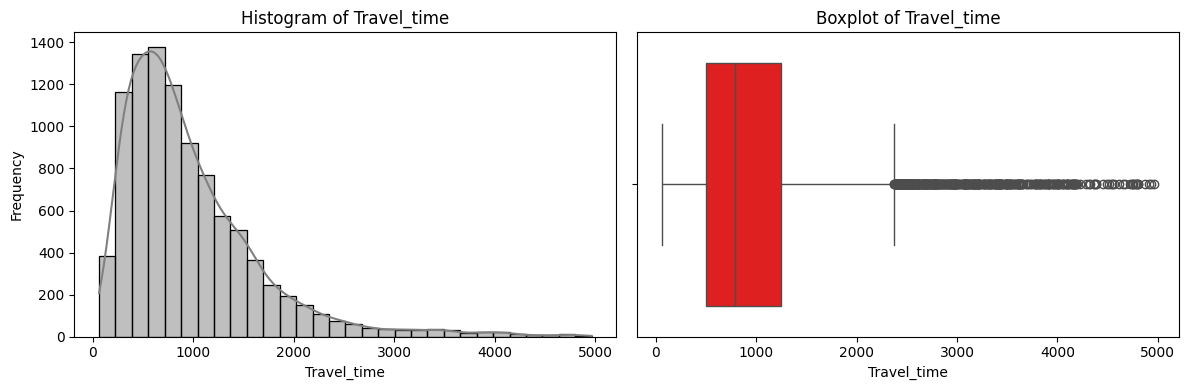

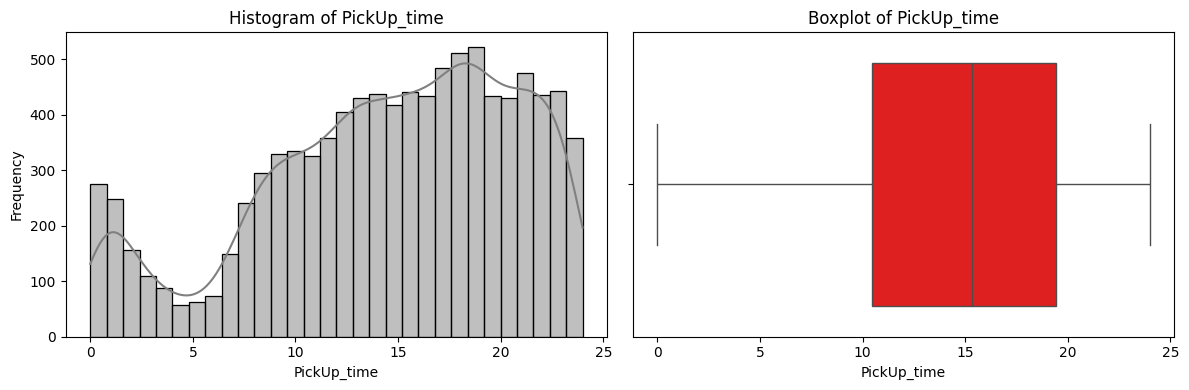

In [33]:
for col in num_cols:
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
    sns.histplot(df[col], kde=True, bins=30, color='grey', ax=axes[0])
    axes[0].set_title(f'Histogram of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    sns.boxplot(x=df[col], color='red', ax=axes[1])
    axes[1].set_title(f'Boxplot of {col}')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

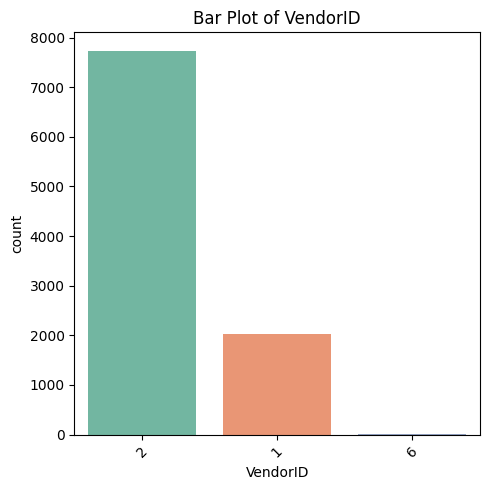

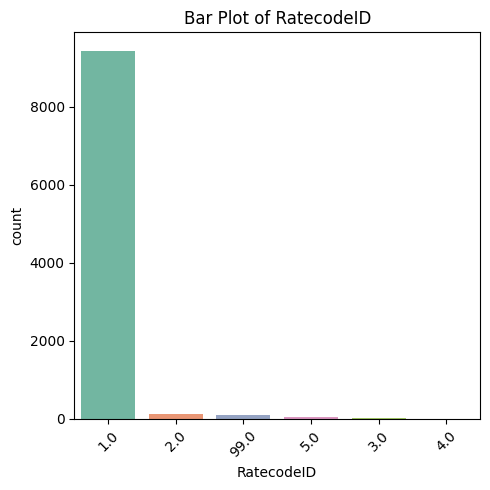

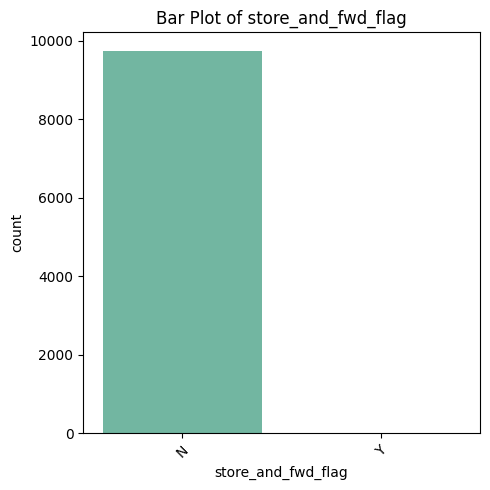

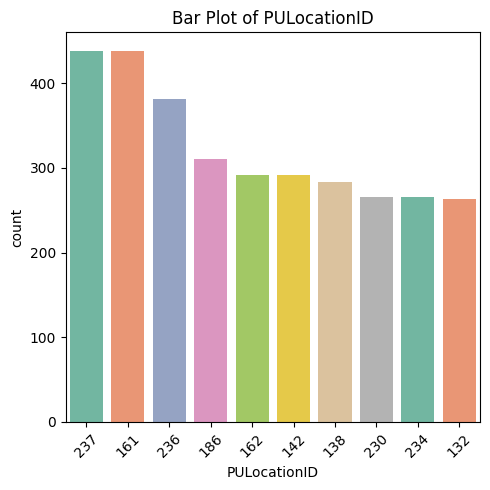

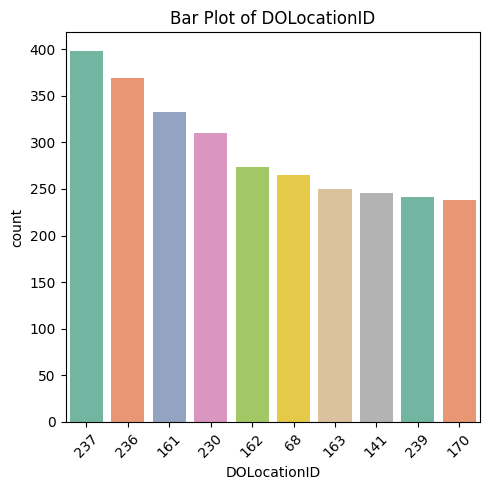

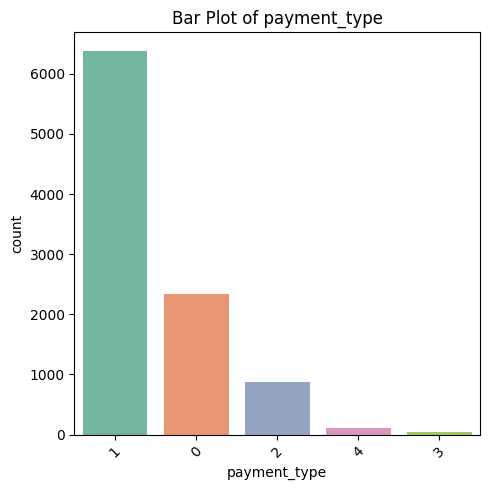

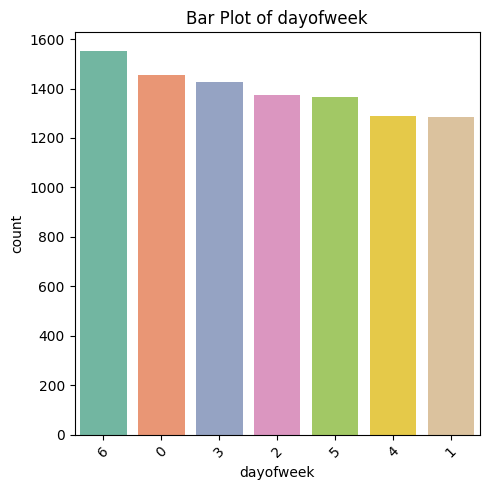

In [34]:
for col in cat_cols:
    
    plt.figure(figsize=(5, 5))
    sns.countplot(data=df, x=col, order=df[col].value_counts().iloc[:10].index, palette='Set2')
    plt.title(f'Bar Plot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Value Counts
isnight
False    7119
True     2624
Name: count, dtype: int64


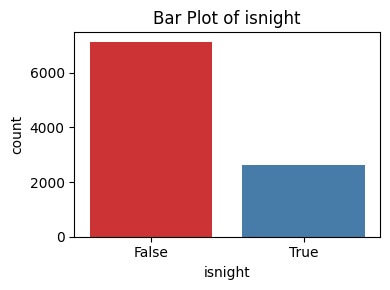

In [35]:
for col in bool_cols:
    print(f"\nValue Counts")
    print(df[col].value_counts())
    plt.figure(figsize=(4, 3))
    sns.countplot(x=df[col], palette='Set1')
    plt.title(f'Bar Plot of {col}')
    plt.tight_layout()
    plt.show()

## Bivariate Analysis

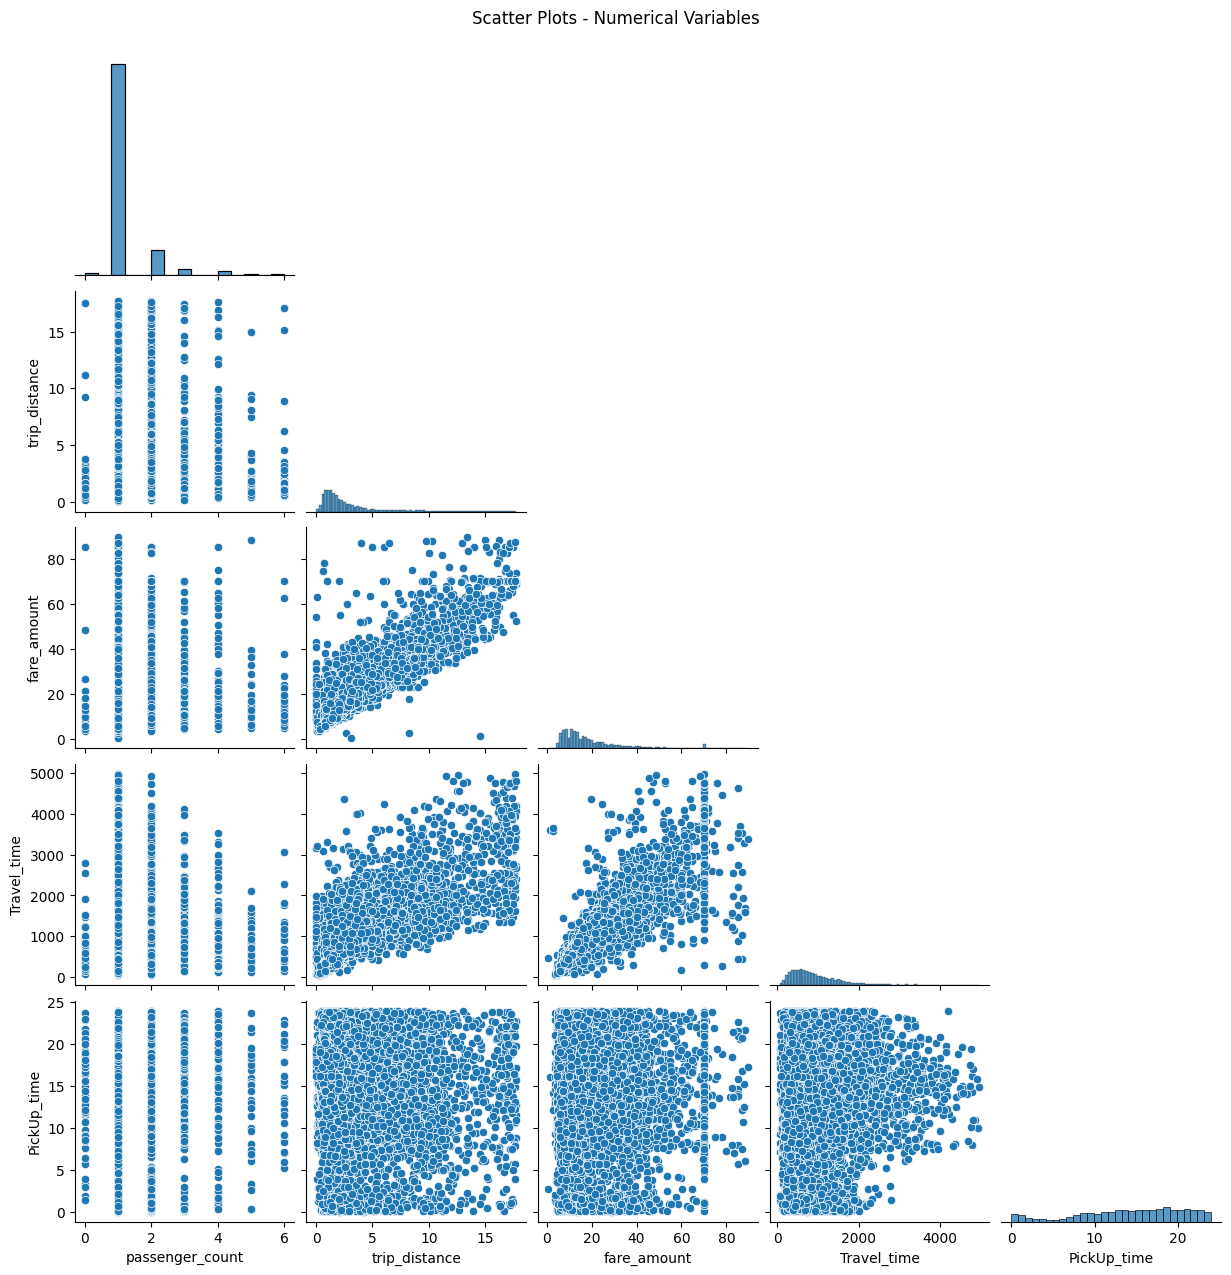

In [36]:
sns.pairplot(df[num_cols], corner=True)
plt.suptitle("Scatter Plots - Numerical Variables", y=1.02)
plt.show()

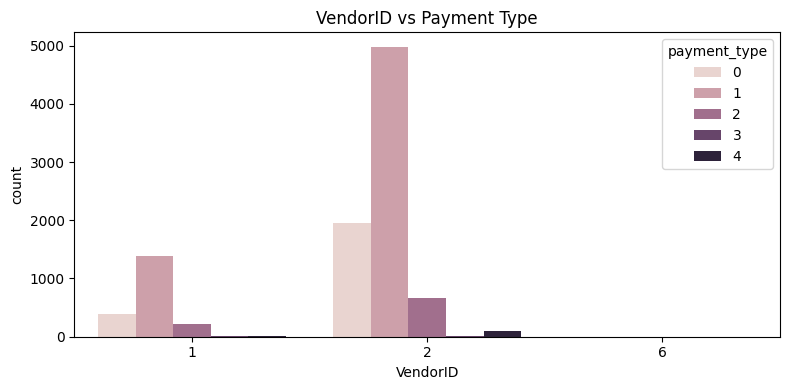

In [37]:
# VendorID vs payment_type
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='VendorID', hue='payment_type')
plt.title("VendorID vs Payment Type")
plt.tight_layout()
plt.show()

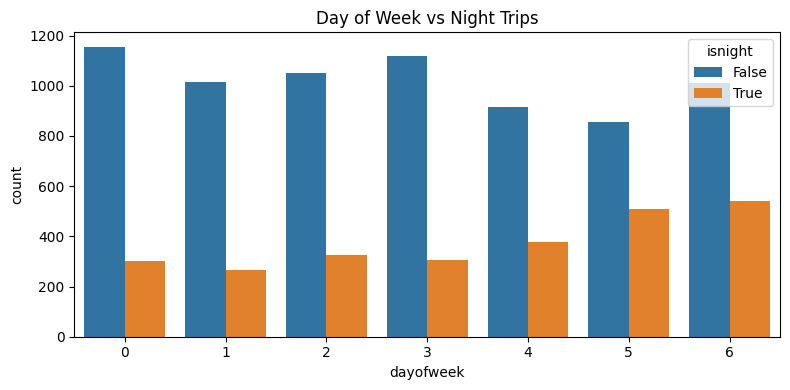

In [38]:
#isnight vs dayofweek
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='dayofweek', hue='isnight')
plt.title("Day of Week vs Night Trips")
plt.tight_layout()
plt.show()

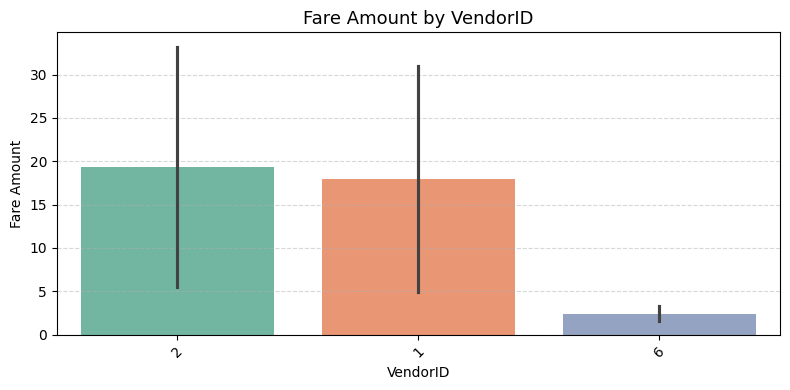

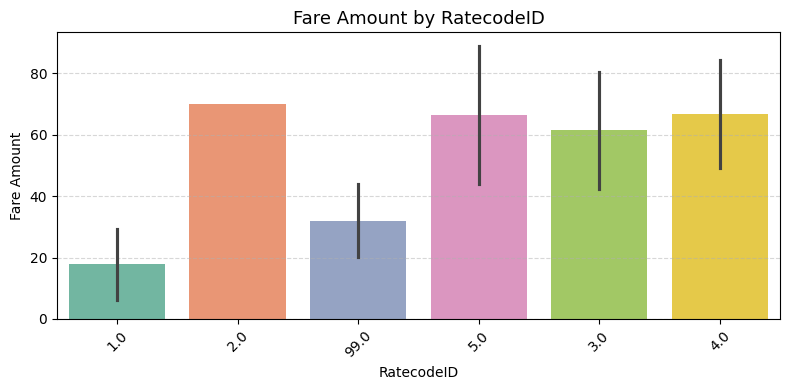

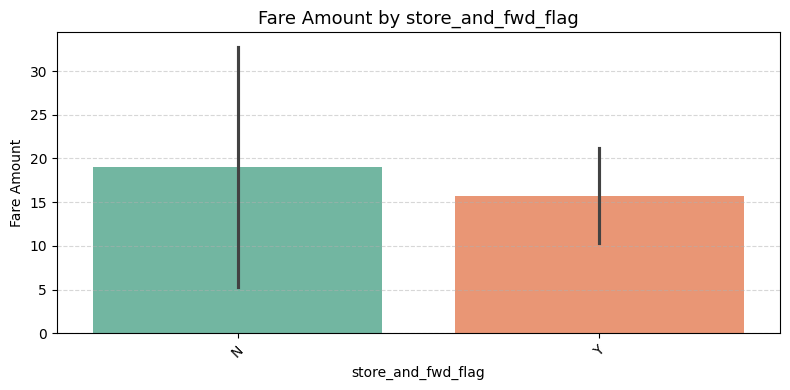

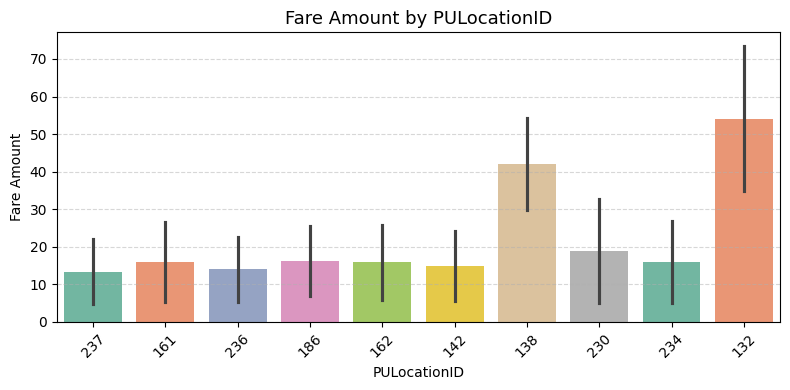

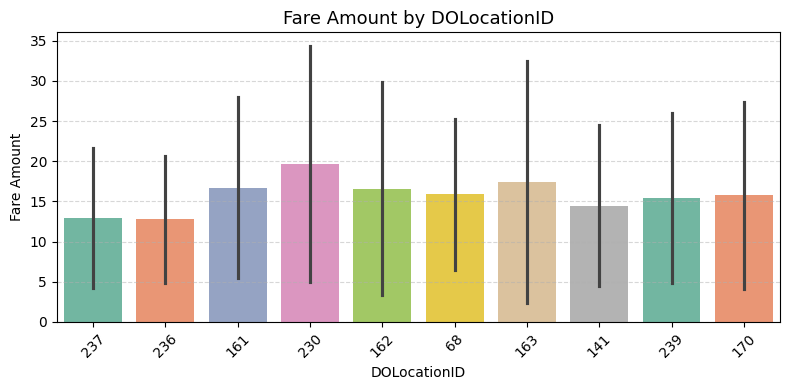

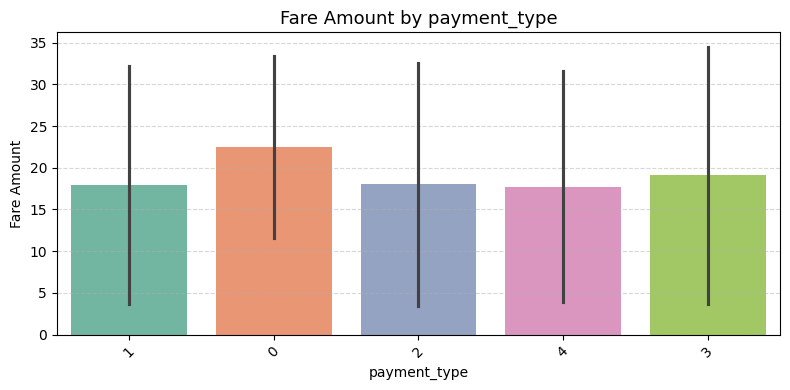

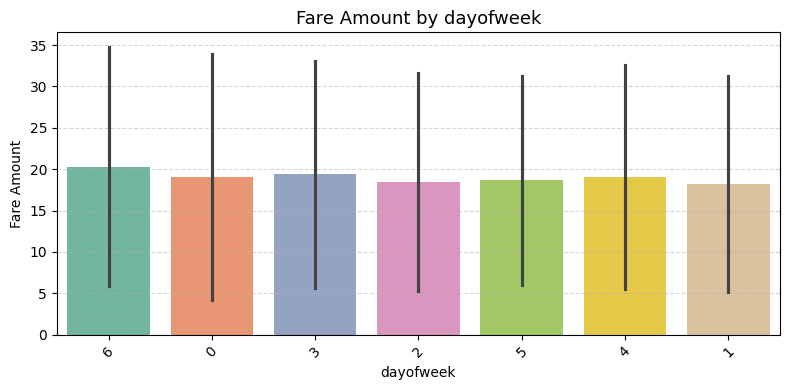

In [39]:
for cat in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x=cat, y='fare_amount', estimator='mean', ci='sd', palette='Set2',order=df[cat].value_counts().iloc[:10].index)
    plt.title(f'Fare Amount by {cat}', fontsize=13)
    plt.xlabel(cat)
    plt.ylabel('Fare Amount')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## Multi-Variate Analysis

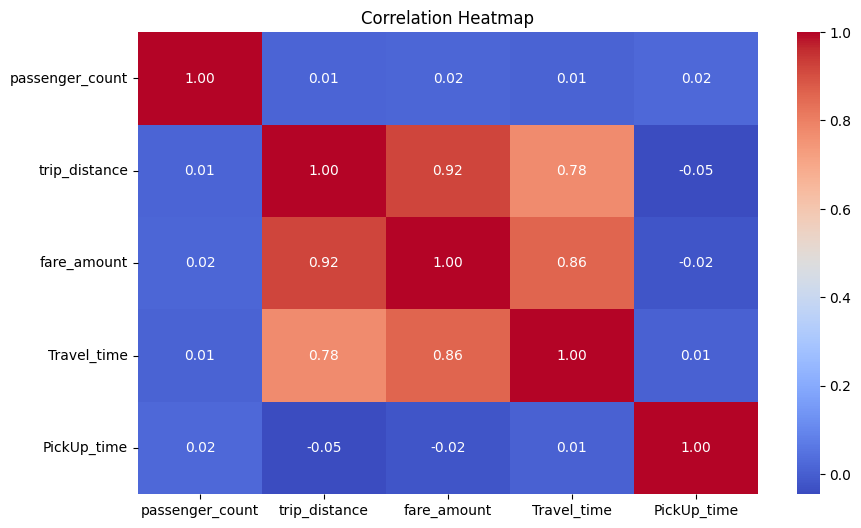

In [40]:
# Correlation matrix

corr = df[num_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# DATA Modeling

## Train / Test Data 

In [41]:
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [42]:
cat_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
            'DOLocationID', 'payment_type', 'dayofweek', 'isnight']
num_cols.remove('fare_amount')

### Creating PipeLine 

In [43]:
pipe = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols) ] )

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=43),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=43),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=43, verbosity=0)
}

### Modeling

In [44]:
results = []

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', pipe),
                               ('regressor', model)])
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})
   

### Evaluate 

In [45]:
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\nModel Comparison:")
print(results_df)


Model Comparison:
               Model      RMSE        R2
2  Gradient Boosting  3.000986  0.948685
1      Random Forest  3.023649  0.947907
3            XGBoost  3.167847  0.942820
0  Linear Regression  3.767611  0.919119


# Conclusion

Choose **Gradient Boosting** if maximum accuracy is the priority—lowest RMSE and best R².

Consider Random Forest for nearly similar performance with possibly faster training.

Use XGBoost if tuning or parallel computation is needed, though it was slightly less accurate here.

Avoid Linear Regression for this problem, as it failed to capture the data’s nonlinear nature.

Overall, ensemble techniques are the recommended solution for this fare prediction task.